In [32]:
import gzip, csv, json, re, itertools, random, time
from pathlib import Path

import torch
from torch.utils.data import DataLoader

from sentence_transformers import models, SentenceTransformer, InputExample, losses, util

import numpy as np
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DATA_DIR      = Path("data/GSEA/external_gene_data/store!")
OUTPUT_DIR    = Path("output/model")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

GENE_FILE     = DATA_DIR / "rat_genes_consolidated.txt.gz"
PATHWAY_FILE  = DATA_DIR / "wikipathways_synonyms_Rattus_norvegicus.gmt.gz"

TRAIN_JSONL   = OUTPUT_DIR / "train.jsonl"
VAL_JSONL     = OUTPUT_DIR / "val.jsonl"
TEST_JSONL    = OUTPUT_DIR / "test.jsonl"

BASE_MODEL    = "michiyasunaga/BioLinkBERT-large"
OUTPUT_FOLDER = OUTPUT_DIR / "biolinkbert-large-simcse-rat"
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"

BATCH_SIZE     = 256
EPOCHS         = 50
LEARNING_RATE  = 3e-5
WARMUP_RATIO   = 0.1

In [33]:
import gzip, csv, json, re, itertools, random
from pathlib import Path

# … your imports, SEED, DATA_DIR, OUTPUT_DIR, etc. …

def add_pairs(pairs, texts):
    texts = [t.strip() for t in texts if t and str(t).strip()]
    for a, b in itertools.combinations(set(texts), 2):
        pairs.append((a, b, 1))

# 1) Build pos_pairs and neg_pairs as before
pos_pairs = []
with gzip.open(GENE_FILE, "rt") as fh:
    rdr = csv.DictReader(fh)
    for row in rdr:
        add_pairs(pos_pairs, [
            row["Gene stable ID"],
            row["Gene name"],
            row["Gene description"]
        ])

bracket_re = re.compile(r"\[([^\]]+)\]")
with gzip.open(PATHWAY_FILE, "rt") as fh:
    for line in fh:
        if not line.strip():
            continue
        pathway = re.sub(r"\s+", " ", line.split("\t")[0]).strip()
        for grp in bracket_re.findall(line):
            syns = [g.strip() for g in grp.split(",") if g.strip()]
            add_pairs(pos_pairs, syns)
            for s in syns:
                pos_pairs.append((pathway, s, 1))

all_texts = list({t for a, b, _ in pos_pairs for t in (a, b)})

pos_set = {(a, b) for a, b, _ in pos_pairs}
neg_pairs = set()
while len(neg_pairs) < len(pos_pairs):
    a, b = random.sample(all_texts, 2)
    if (a, b) in pos_set or (b, a) in pos_set: continue
    if (a, b) in neg_pairs or (b, a) in neg_pairs: continue
    neg_pairs.add((a, b))
neg_pairs = [(a, b, 0) for a, b in neg_pairs]

# 2) Merge positives and negatives
all_pairs = pos_pairs + neg_pairs

# 3) Deduplicate unordered:
uniq = {}
for a, b, label in all_pairs:
    key = tuple(sorted((a, b)))
    if key not in uniq:
        uniq[key] = label
# Rebuild a list of unique (a,b,label)
unique_pairs = [(a, b, lbl) for (a, b), lbl in uniq.items()]

# 4) Shuffle and split
random.shuffle(unique_pairs)
N      = len(unique_pairs)
n_test = int(0.1 * N)
n_rem  = N - n_test
n_val  = n_rem // 9
n_train= n_rem - n_val

splits = {
    "test":  unique_pairs[:n_test],
    "val":   unique_pairs[n_test:n_test+n_val],
    "train": unique_pairs[n_test+n_val:]
}

# 5) Write out
for name, path in [("train", TRAIN_JSONL),
                   ("val",   VAL_JSONL),
                   ("test",  TEST_JSONL)]:
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        for a, b, label in splits[name]:
            json.dump({"text1": a, "text2": b, "label": label}, f, ensure_ascii=False)
            f.write("\n")

print(f"✅ Train={len(splits['train']):,}  Val={len(splits['val']):,}  Test={len(splits['test']):,}")


✅ Train=180,795  Val=22,599  Test=22,599


In [12]:
from datasets import Dataset
from torch.utils.data import DataLoader
from sentence_transformers import (
    models,
    SentenceTransformer,
    InputExample,
    losses,
    SentenceTransformerTrainer,
    SentenceTransformerTrainingArguments
)
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from transformers import EarlyStoppingCallback
import json

# ── 0) Re-create your SBERT model & loss ──
# (This was originally in Cell 3 of your first snippet)
word_model = models.Transformer(BASE_MODEL, max_seq_length=128)
word_model.auto_model.gradient_checkpointing_enable()
pooling = models.Pooling(
    word_model.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True
)
model = SentenceTransformer(modules=[word_model, pooling], device=DEVICE)
loss = losses.ContrastiveLoss(model=model)

# ── 1) Load JSONL splits and build InputExamples ──
train_data = [json.loads(l) for l in TRAIN_JSONL.open("r", encoding="utf-8")]
val_data   = [json.loads(l) for l in VAL_JSONL.open("r", encoding="utf-8")]

train_examples = [
    InputExample(texts=[d["text1"], d["text2"]], label=d["label"])
    for d in train_data
]
val_examples = [
    InputExample(texts=[d["text1"], d["text2"]], label=d["label"])
    for d in val_data
]

# ── 2) Build DataLoaders (for eval_steps/save_steps) ──
train_loader = DataLoader(
    train_examples,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)
val_loader = DataLoader(
    val_examples,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False
)

# ── 3) Convert to HF Datasets for Trainer ──
train_ds = Dataset.from_list([
    {"text1": ex.texts[0], "text2": ex.texts[1], "label": ex.label}
    for ex in train_examples
])
val_ds = Dataset.from_list([
    {"text1": ex.texts[0], "text2": ex.texts[1], "label": ex.label}
    for ex in val_examples
])

# ── 4) Evaluator for validation ──
evaluator = EmbeddingSimilarityEvaluator.from_input_examples(
    val_examples, name='val-eval'
)

# ── 5) Training arguments with HF-style eval/save & early stopping ──
training_args = SentenceTransformerTrainingArguments(
    output_dir=str(OUTPUT_FOLDER),
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    warmup_ratio=WARMUP_RATIO,
    eval_strategy="steps",
    eval_steps=len(train_loader),
    save_strategy="steps",
    save_steps=len(train_loader),
    load_best_model_at_end=True,
    metric_for_best_model="eval_val-eval_spearman_cosine",  # ← match one of the returned keys
    greater_is_better=True,
)


# ── 6) Build the Trainer with EarlyStoppingCallback ──
trainer = SentenceTransformerTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    loss=loss,
    evaluator=evaluator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

# ── 7) Kick off training ──
trainer.train()


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss


KeyboardInterrupt: 

Batches:   0%|          | 0/190 [00:00<?, ?it/s]

Saved plot to output\model\PNG\base_30_epochs.png


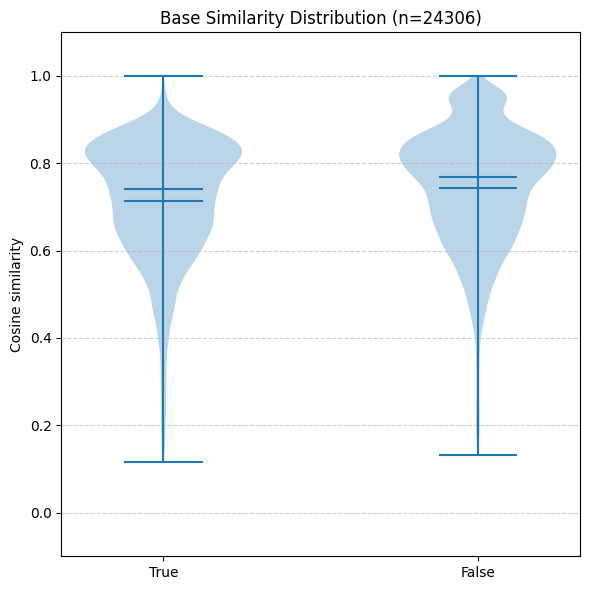

Saved plot to output\model\PNG\fine-tuned_30_epochs.png


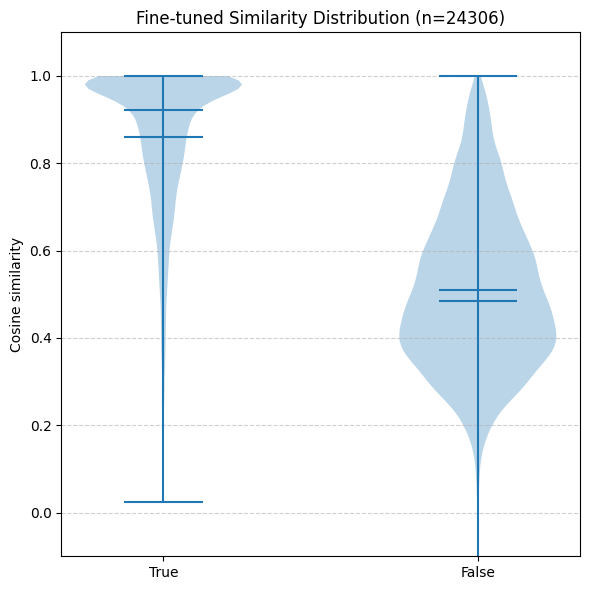

In [5]:
test_data = [json.loads(l) for l in TEST_JSONL.open("r", encoding="utf-8")]

t1     = [d['text1'] for d in test_data]
t2     = [d['text2'] for d in test_data]
labels = np.array([d['label'] for d in test_data])

word_model_base = models.Transformer(BASE_MODEL, max_seq_length=128)
word_model_base.auto_model.gradient_checkpointing_enable()
pool_base = models.Pooling(word_model_base.get_word_embedding_dimension(),
                           pooling_mode_mean_tokens=True)
base_model = SentenceTransformer(modules=[word_model_base, pool_base], device=DEVICE)
OUTPUT_FOLDER_NEW = OUTPUT_FOLDER / "checkpoint-22011"
fine_model = SentenceTransformer(str(OUTPUT_FOLDER_NEW), device=DEVICE)

batch_size_encode = 128
emb_b1 = base_model.encode(t1, batch_size=batch_size_encode,
                           convert_to_tensor=True, show_progress_bar=True)
emb_b2 = base_model.encode(t2, batch_size=batch_size_encode,
                           convert_to_tensor=True, show_progress_bar=False)
emb_f1 = fine_model.encode(t1, batch_size=batch_size_encode,
                           convert_to_tensor=True, show_progress_bar=False)
emb_f2 = fine_model.encode(t2, batch_size=batch_size_encode,
                           convert_to_tensor=True, show_progress_bar=False)

sims = {
    'Base':       util.cos_sim(emb_b1, emb_b2).diag().cpu().numpy(),
    'Fine-tuned': util.cos_sim(emb_f1, emb_f2).diag().cpu().numpy()
}

for name, arr in sims.items():
    true_vals  = arr[labels == 1]
    false_vals = arr[labels == 0]
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.violinplot([true_vals, false_vals], showmeans=True, showmedians=True)
    ax.set_title(f"{name} Similarity Distribution (n={len(test_data)})")
    ax.set_xticks([1, 2]); ax.set_xticklabels(["True", "False"])
    ax.set_ylabel("Cosine similarity")
    ax.grid(True, axis="y", linestyle="--", alpha=0.6)
    ax.set_ylim(-0.1, 1.1)
    plt.tight_layout()
    # Save figure using the number of epochs in filename
    save_path = OUTPUT_DIR/ "PNG" / f"{name.lower()}_{EPOCHS}_epochs.png"
    fig.savefig(save_path)
    print(f"Saved plot to {save_path}")
    plt.show()

30
Evaluating base model…
  [Epoch 0] Val Spearman = -0.072651, Test Spearman = -0.095272
Evaluating checkpoint at epoch 759…
  [Epoch 759] Val Spearman = 0.397949, Test Spearman = 0.403786
Evaluating checkpoint at epoch 1518…
  [Epoch 1518] Val Spearman = 0.618588, Test Spearman = 0.621797
Evaluating checkpoint at epoch 2277…
  [Epoch 2277] Val Spearman = 0.648558, Test Spearman = 0.650069
Evaluating checkpoint at epoch 3036…
  [Epoch 3036] Val Spearman = 0.654664, Test Spearman = 0.656414
Evaluating checkpoint at epoch 3795…
  [Epoch 3795] Val Spearman = 0.671930, Test Spearman = 0.670846
Evaluating checkpoint at epoch 4554…
  [Epoch 4554] Val Spearman = 0.681602, Test Spearman = 0.682312
Evaluating checkpoint at epoch 5313…
  [Epoch 5313] Val Spearman = 0.684127, Test Spearman = 0.686725
Evaluating checkpoint at epoch 6072…
  [Epoch 6072] Val Spearman = 0.693946, Test Spearman = 0.695354
Evaluating checkpoint at epoch 6831…
  [Epoch 6831] Val Spearman = 0.693831, Test Spearman = 0.6

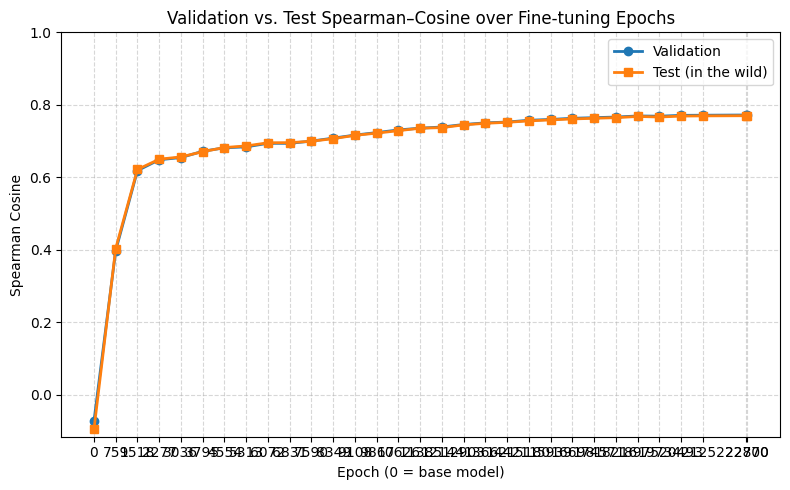

In [2]:
import matplotlib.pyplot as plt
import json
from pathlib import Path

from sentence_transformers import models, SentenceTransformer, InputExample
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

# ── 0) Build the BioLinkBERT‐Large base model with mean pooling ──
word_model = models.Transformer(
    "michiyasunaga/BioLinkBERT-large",
    max_seq_length=128,
)
pooling = models.Pooling(
    word_model.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True
)
base_model = SentenceTransformer(
    modules=[word_model, pooling],
    device=DEVICE
)

# ── 1) Prepare evaluators ──
store_dir = OUTPUT_FOLDER / "store"

val_data = [json.loads(l) for l in VAL_JSONL.open("r", encoding="utf-8")]
val_examples = [
    InputExample(texts=[d["text1"], d["text2"]], label=d["label"])
    for d in val_data
]
evaluator_val = EmbeddingSimilarityEvaluator.from_input_examples(
    val_examples, name="val-eval"
)

test_data = [json.loads(l) for l in TEST_JSONL.open("r", encoding="utf-8")]
test_examples = [
    InputExample(texts=[d["text1"], d["text2"]], label=d["label"])
    for d in test_data
]
evaluator_test = EmbeddingSimilarityEvaluator.from_input_examples(
    test_examples, name="test-eval"
)

# ── 2) Locate all checkpoint directories ──
ckpts = sorted(
    [d for d in store_dir.iterdir() if d.is_dir() and d.name.startswith("checkpoint-")],
    key=lambda d: int(d.name.split("-")[1])
)

# ── 3) Evaluate base model + each checkpoint ──
epochs = []       # first entry will be your base model
val_scores = []
test_scores = []

# Base model
print("Evaluating base model…")
metrics_val = evaluator_val(base_model, output_path=None)
metrics_test = evaluator_test(base_model, output_path=None)
base_val = metrics_val["val-eval_spearman_cosine"]
base_test = metrics_test["test-eval_spearman_cosine"]
print(f"  [Base Model] Val Spearman = {base_val:.6f}, Test Spearman = {base_test:.6f}")
epochs.append(BASE_MODEL)
val_scores.append(base_val)
test_scores.append(base_test)

# Fine‐tuned checkpoints (labelled 1, 2, 3, …)
for idx, ckpt in enumerate(ckpts, start=1):
    print(f"Evaluating checkpoint at epoch {idx} ({ckpt.name})…")
    model = SentenceTransformer(str(ckpt), device=DEVICE)
    metrics_val = evaluator_val(model, output_path=None)
    metrics_test = evaluator_test(model, output_path=None)
    val_sp = metrics_val["val-eval_spearman_cosine"]
    test_sp = metrics_test["test-eval_spearman_cosine"]
    print(f"  [Epoch {idx}] Val Spearman = {val_sp:.6f}, Test Spearman = {test_sp:.6f}")
    epochs.append(idx)
    val_scores.append(val_sp)
    test_scores.append(test_sp)




In [24]:
from pathlib import Path
import json

# ── Prepare output directory ──
output_dir = Path("./output/text_files/PNG_HTML")
output_dir.mkdir(parents=True, exist_ok=True)

# ── Save raw Spearman values for later reuse ──
values = {
    "epochs":     epochs,      # now matches Cell 1
    "val_scores": val_scores,
    "test_scores": test_scores
}
with open(output_dir / "spearman_values.json", "w") as f:
    json.dump(values, f)


In [28]:
from pathlib import Path
import plotly.graph_objects as go

# ── Prepare output directory ──
output_dir = Path("./output/text_files/PNG_HTML")
output_dir.mkdir(parents=True, exist_ok=True)

# Numeric positions and labels
positions = list(range(len(epochs)))
labels = [str(e) for e in epochs]  # e.g. "michiyasunaga/BioLinkBERT-large", "1", "2", …

# ── 1) Validation-only plot ──
fig_val = go.Figure()
fig_val.add_trace(go.Scatter(
    x=positions, y=val_scores, mode="lines+markers", name="Validation"
))
fig_val.update_layout(
    title="Validation Spearman–Cosine over Base Model + Epochs",
    xaxis=dict(
        title="Model / Epoch",
        tickmode="array",
        tickvals=positions,
        ticktext=labels,
        tickangle=45
    ),
    yaxis=dict(title="Spearman Cosine", range=[min(val_scores) - 0.02, 1.0])
)
val_path = output_dir / "spearman_validation.html"
fig_val.write_html(str(val_path), include_plotlyjs="cdn")

# ── 2) Test-only plot ──
fig_test = go.Figure()
fig_test.add_trace(go.Scatter(
    x=positions, y=test_scores, mode="lines+markers", name="Test"
))
fig_test.update_layout(
    title="Test Spearman–Cosine (in the wild) over Base Model + Epochs",
    xaxis=dict(
        title="Model / Epoch",
        tickmode="array",
        tickvals=positions,
        ticktext=labels,
        tickangle=45
    ),
    yaxis=dict(title="Spearman Cosine", range=[min(test_scores) - 0.02, 1.0])
)
test_path = output_dir / "spearman_test.html"
fig_test.write_html(str(test_path), include_plotlyjs="cdn")

# ── 3) Combined plot ──
fig_comb = go.Figure()
fig_comb.add_trace(go.Scatter(
    x=positions, y=val_scores, mode="lines+markers", name="Validation"
))
fig_comb.add_trace(go.Scatter(
    x=positions, y=test_scores, mode="lines+markers", name="Test"
))
fig_comb.update_layout(
    title="Validation & Test Spearman–Cosine over Base Model + Epochs",
    xaxis=dict(
        title="Model / Epoch",
        tickmode="array",
        tickvals=positions,
        ticktext=labels,
        tickangle=45
    ),
    yaxis=dict(title="Spearman Cosine", range=[min(val_scores + test_scores) - 0.02, 1.0])
)
comb_path = output_dir / "spearman_combined.html"
fig_comb.write_html(str(comb_path), include_plotlyjs="cdn")

print(f"Saved:\n  {val_path}\n  {test_path}\n  {comb_path}")


Saved:
  output\text_files\PNG_HTML\spearman_validation.html
  output\text_files\PNG_HTML\spearman_test.html
  output\text_files\PNG_HTML\spearman_combined.html


In [34]:
#!/usr/bin/env python3
import json
from pathlib import Path

def load_pairs(path):
    """
    Load all (text1, text2) pairs from a .jsonl file,
    canonicalizing order so (A,B) == (B,A).
    Returns a set of tuple pairs.
    """
    pairs = set()
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            data = json.loads(line)
            a, b = data["text1"], data["text2"]
            # sort the two so order doesn’t matter
            pair = tuple(sorted((a, b)))
            pairs.add(pair)
    return pairs

def report_overlap(s1, s2, name1, name2):
    overlap = s1 & s2
    if overlap:
        print(f"🔴 Overlap between {name1} and {name2}: {len(overlap)} shared pairs")
        for pair in list(overlap)[:10]:
            print("   ", pair)
    else:
        print(f"✅ No overlap between {name1} and {name2}")

def main():
    base = Path("./output/model/")
    files = {
        "train": base / "train.jsonl",
        "val":   base / "val.jsonl",
        "test":  base / "test.jsonl",
    }

    # Load
    print("Loading splits…")
    splits = {name: load_pairs(path) for name, path in files.items()}
    for name, s in splits.items():
        print(f"  {name}: {len(s)} unique pairs")

    print("\nChecking overlaps:")
    report_overlap(splits["train"], splits["val"],   "train", "val")
    report_overlap(splits["train"], splits["test"],  "train", "test")
    report_overlap(splits["val"],   splits["test"],  "val",   "test")

if __name__ == "__main__":
    main()


Loading splits…
  train: 180795 unique pairs
  val: 22599 unique pairs
  test: 22599 unique pairs

Checking overlaps:
✅ No overlap between train and val
✅ No overlap between train and test
✅ No overlap between val and test


In [ ]:
from huggingface_hub import HfApi
import os
api = HfApi(token=os.getenv("HF_TOKEN"))
api.upload_folder(
    folder_path="./output/model/biolinkbert-large-simcse-rat/best_model",
    repo_id="mghuibregtse/biolinkbert-large-simcse-rat",
    repo_type="model",
)


model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/2.66G [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.6k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/6.03k [00:00<?, ?B/s]

Upload 5 LFS files:   0%|          | 0/5 [00:00<?, ?it/s]

scheduler.pt:   0%|          | 0.00/1.47k [00:00<?, ?B/s]